### Scale Space Technique

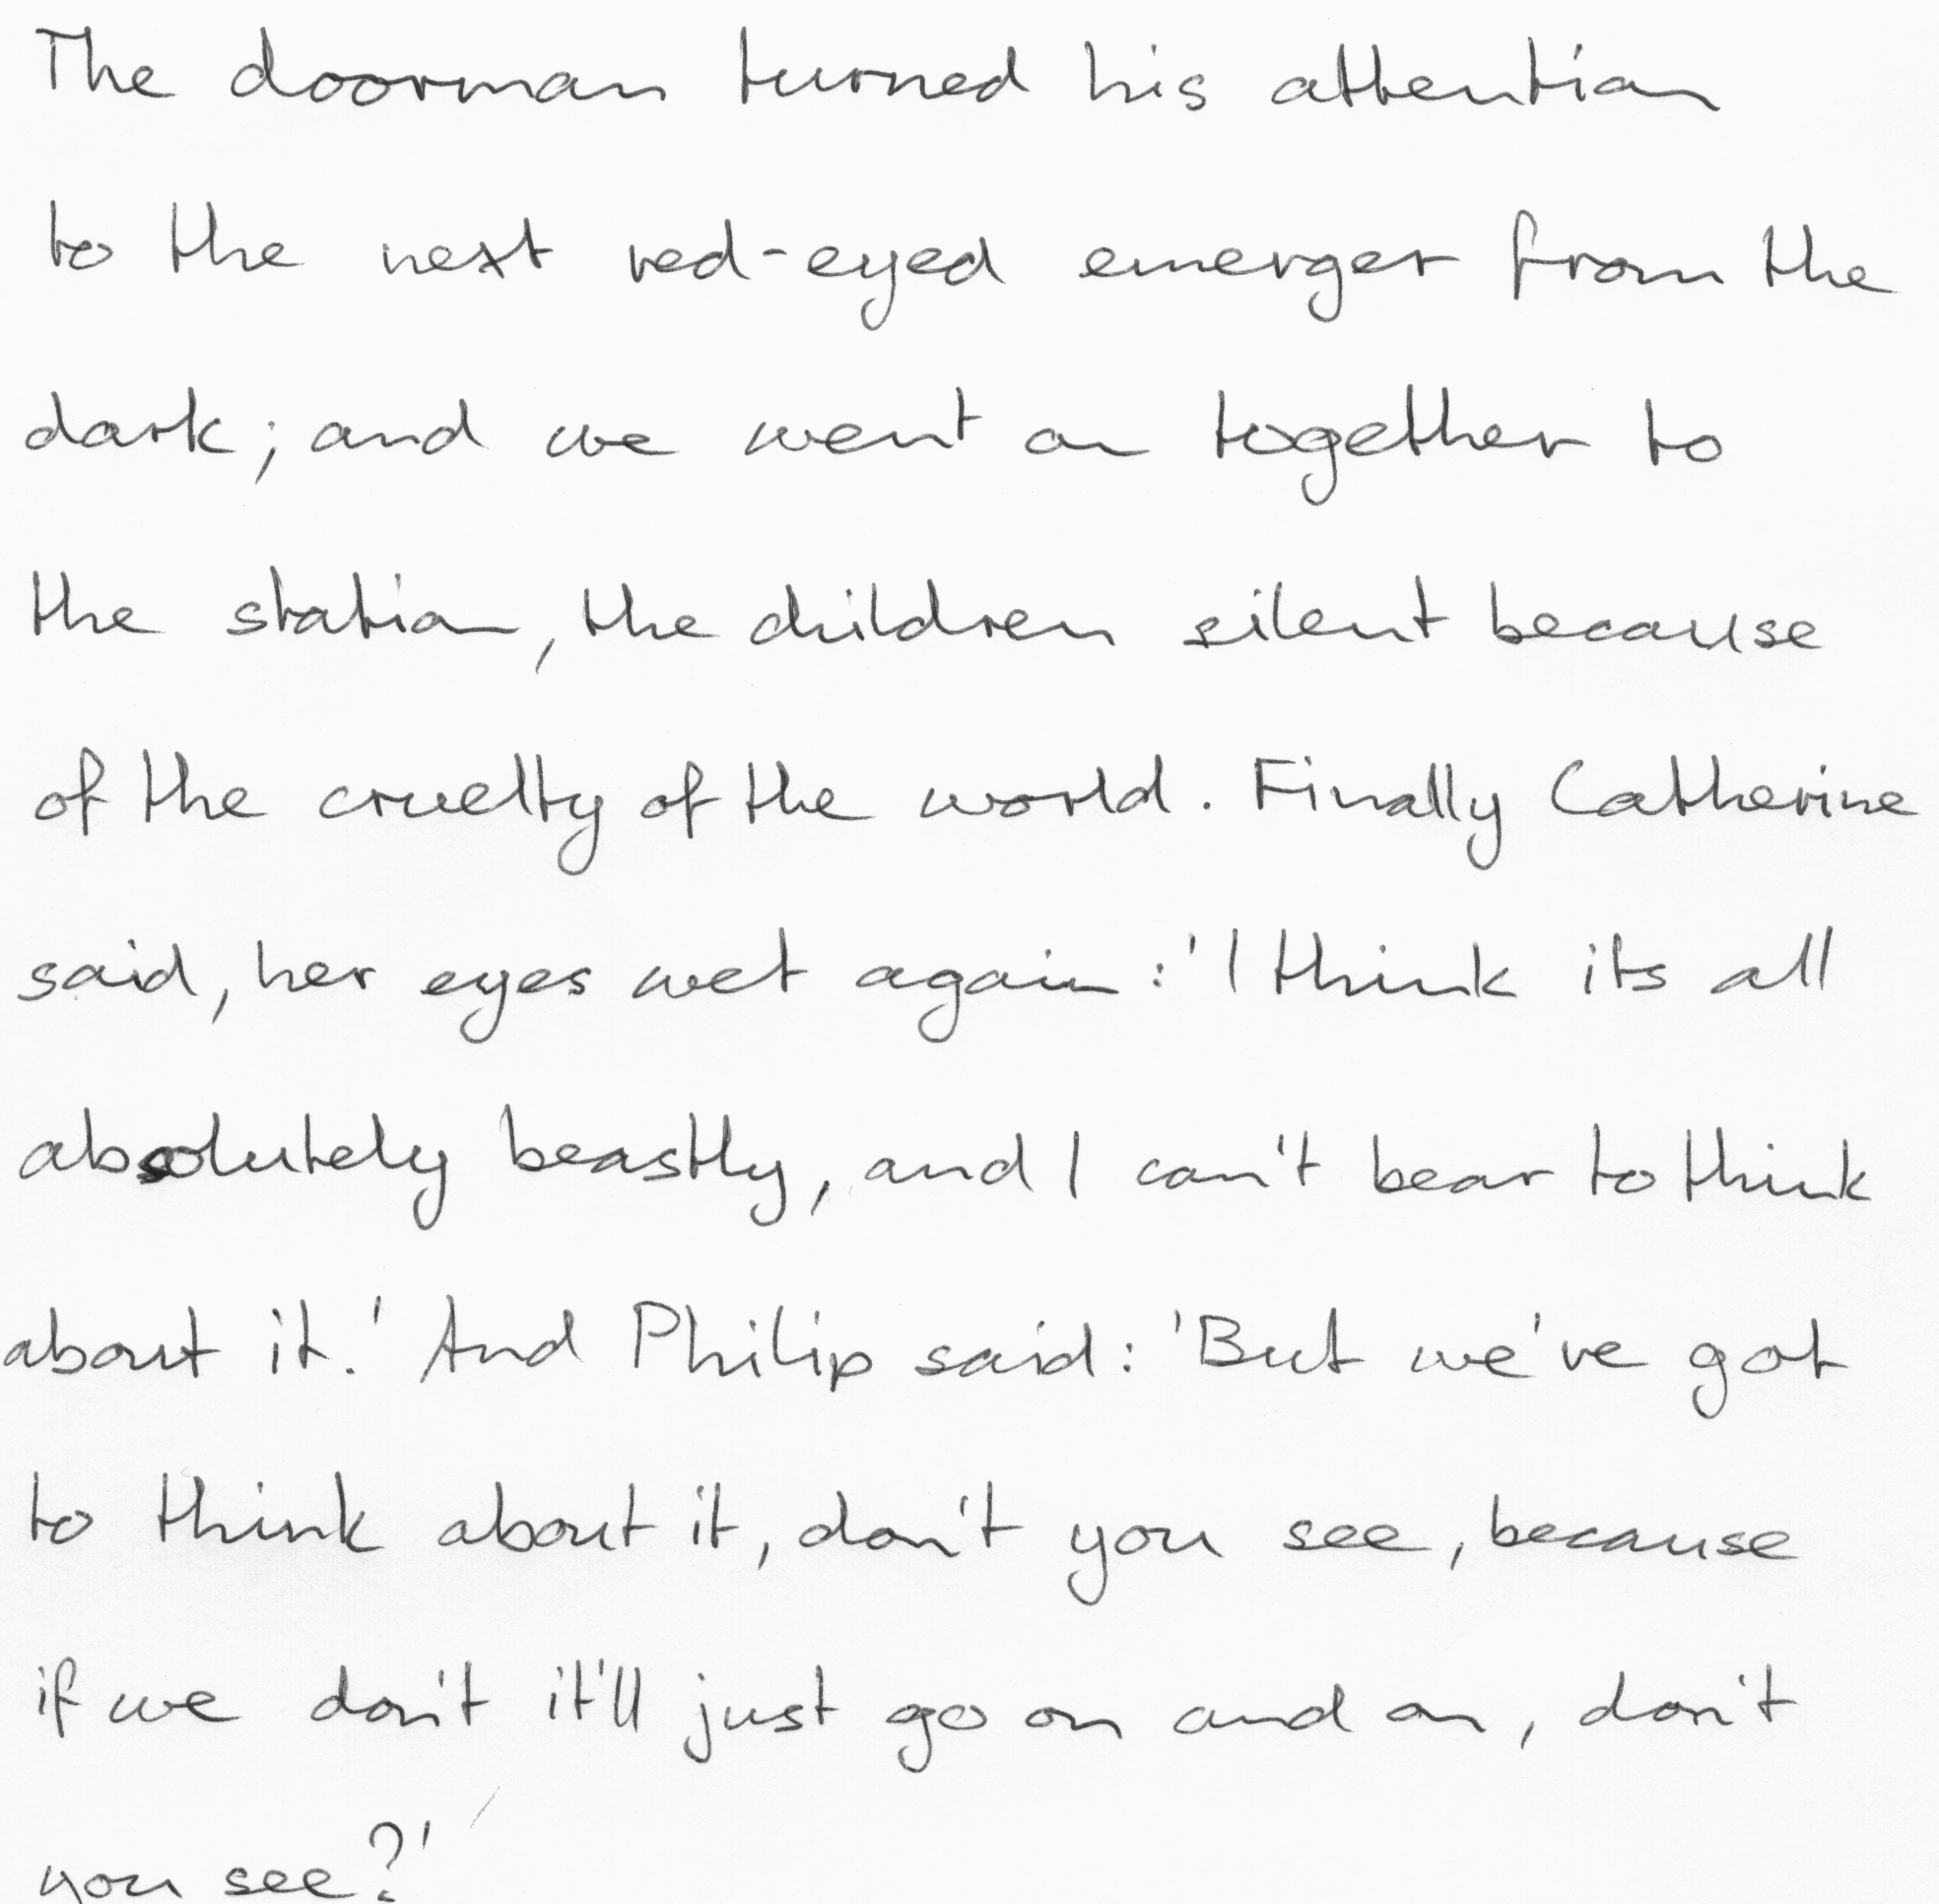

name_crop (1932, 1968)


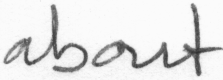

wordImg (80, 223)


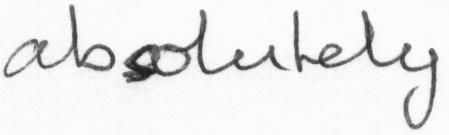

wordImg (135, 449)


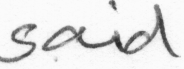

wordImg (69, 184)


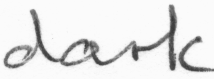

wordImg (79, 214)


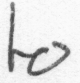

wordImg (83, 80)


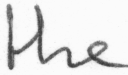

wordImg (75, 128)


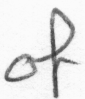

wordImg (99, 85)


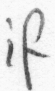

wordImg (91, 55)


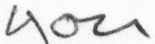

wordImg (44, 155)


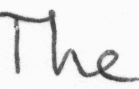

wordImg (89, 139)


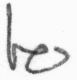

wordImg (80, 77)


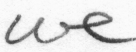

wordImg (52, 136)


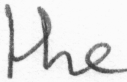

wordImg (82, 127)


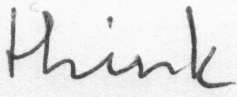

wordImg (97, 237)


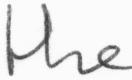

wordImg (80, 132)


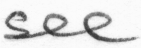

wordImg (48, 141)


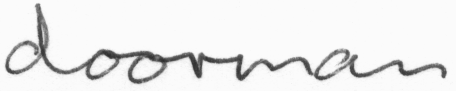

wordImg (91, 456)


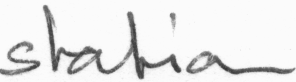

wordImg (82, 296)


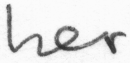

wordImg (63, 130)


wordImg (37, 26)


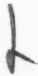

wordImg (76, 38)


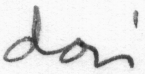

wordImg (74, 145)


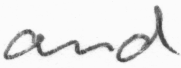

wordImg (68, 181)


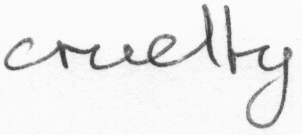

wordImg (135, 302)


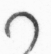

wordImg (54, 51)


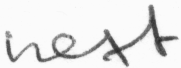

wordImg (68, 181)


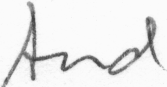

wordImg (87, 167)


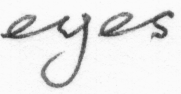

wordImg (94, 181)


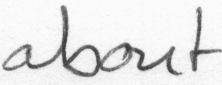

wordImg (85, 222)


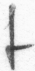

wordImg (71, 35)


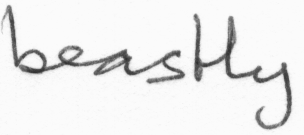

wordImg (135, 304)


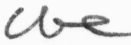

wordImg (45, 131)


wordImg (66, 31)


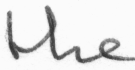

wordImg (70, 135)


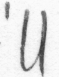

wordImg (77, 59)


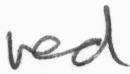

wordImg (74, 130)


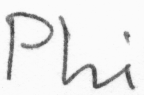

wordImg (95, 144)


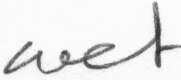

wordImg (80, 181)


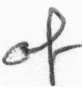

wordImg (87, 82)


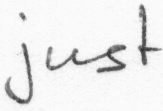

wordImg (111, 163)


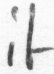

wordImg (74, 54)


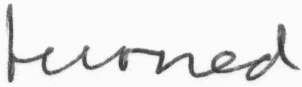

wordImg (87, 302)


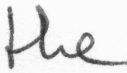

wordImg (73, 127)


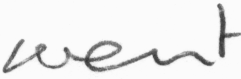

wordImg (79, 241)


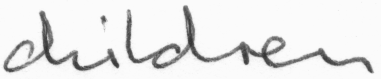

wordImg (79, 381)


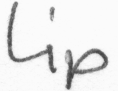

wordImg (91, 118)


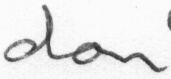

wordImg (79, 171)


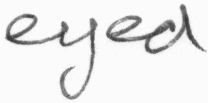

wordImg (103, 208)


wordImg (37, 30)


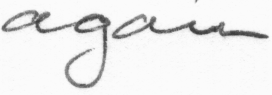

wordImg (95, 272)


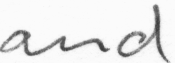

wordImg (63, 175)


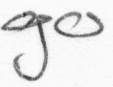

wordImg (87, 113)


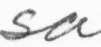

wordImg (47, 101)


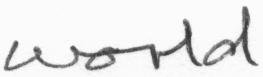

wordImg (77, 263)


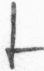

wordImg (71, 44)


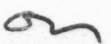

wordImg (44, 111)


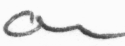

wordImg (46, 125)


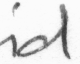

wordImg (64, 80)


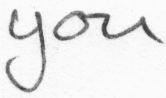

wordImg (98, 166)


wordImg (71, 28)


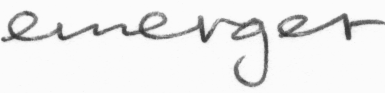

wordImg (93, 385)


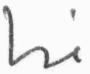

wordImg (74, 90)


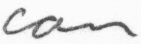

wordImg (44, 141)


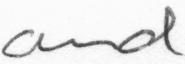

wordImg (64, 185)


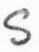

wordImg (52, 39)


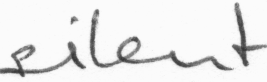

wordImg (82, 267)


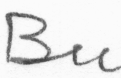

wordImg (78, 121)


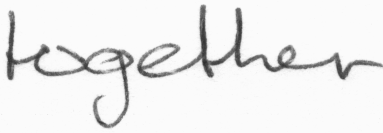

wordImg (133, 383)


wordImg (61, 26)


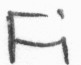

wordImg (65, 81)


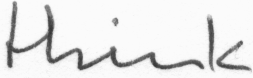

wordImg (78, 253)


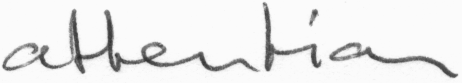

wordImg (83, 462)


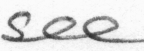

wordImg (51, 144)


wordImg (55, 30)


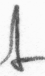

wordImg (76, 45)


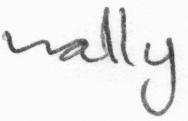

wordImg (121, 188)


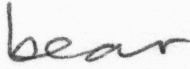

wordImg (69, 190)


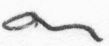

wordImg (46, 109)


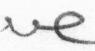

wordImg (51, 95)


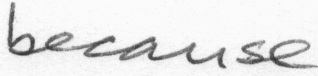

wordImg (76, 318)


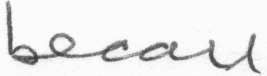

wordImg (76, 267)


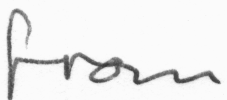

wordImg (100, 227)


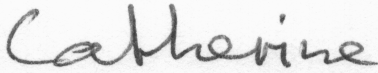

wordImg (73, 378)


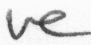

wordImg (45, 91)


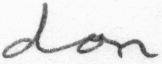

wordImg (64, 162)


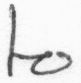

wordImg (83, 81)


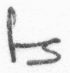

wordImg (73, 70)


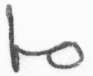

wordImg (76, 93)


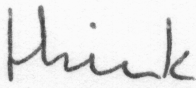

wordImg (88, 196)


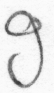

wordImg (93, 54)


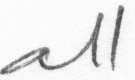

wordImg (80, 135)


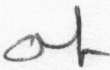

wordImg (70, 110)


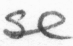

wordImg (46, 73)


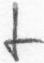

wordImg (63, 44)


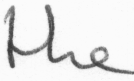

wordImg (81, 134)


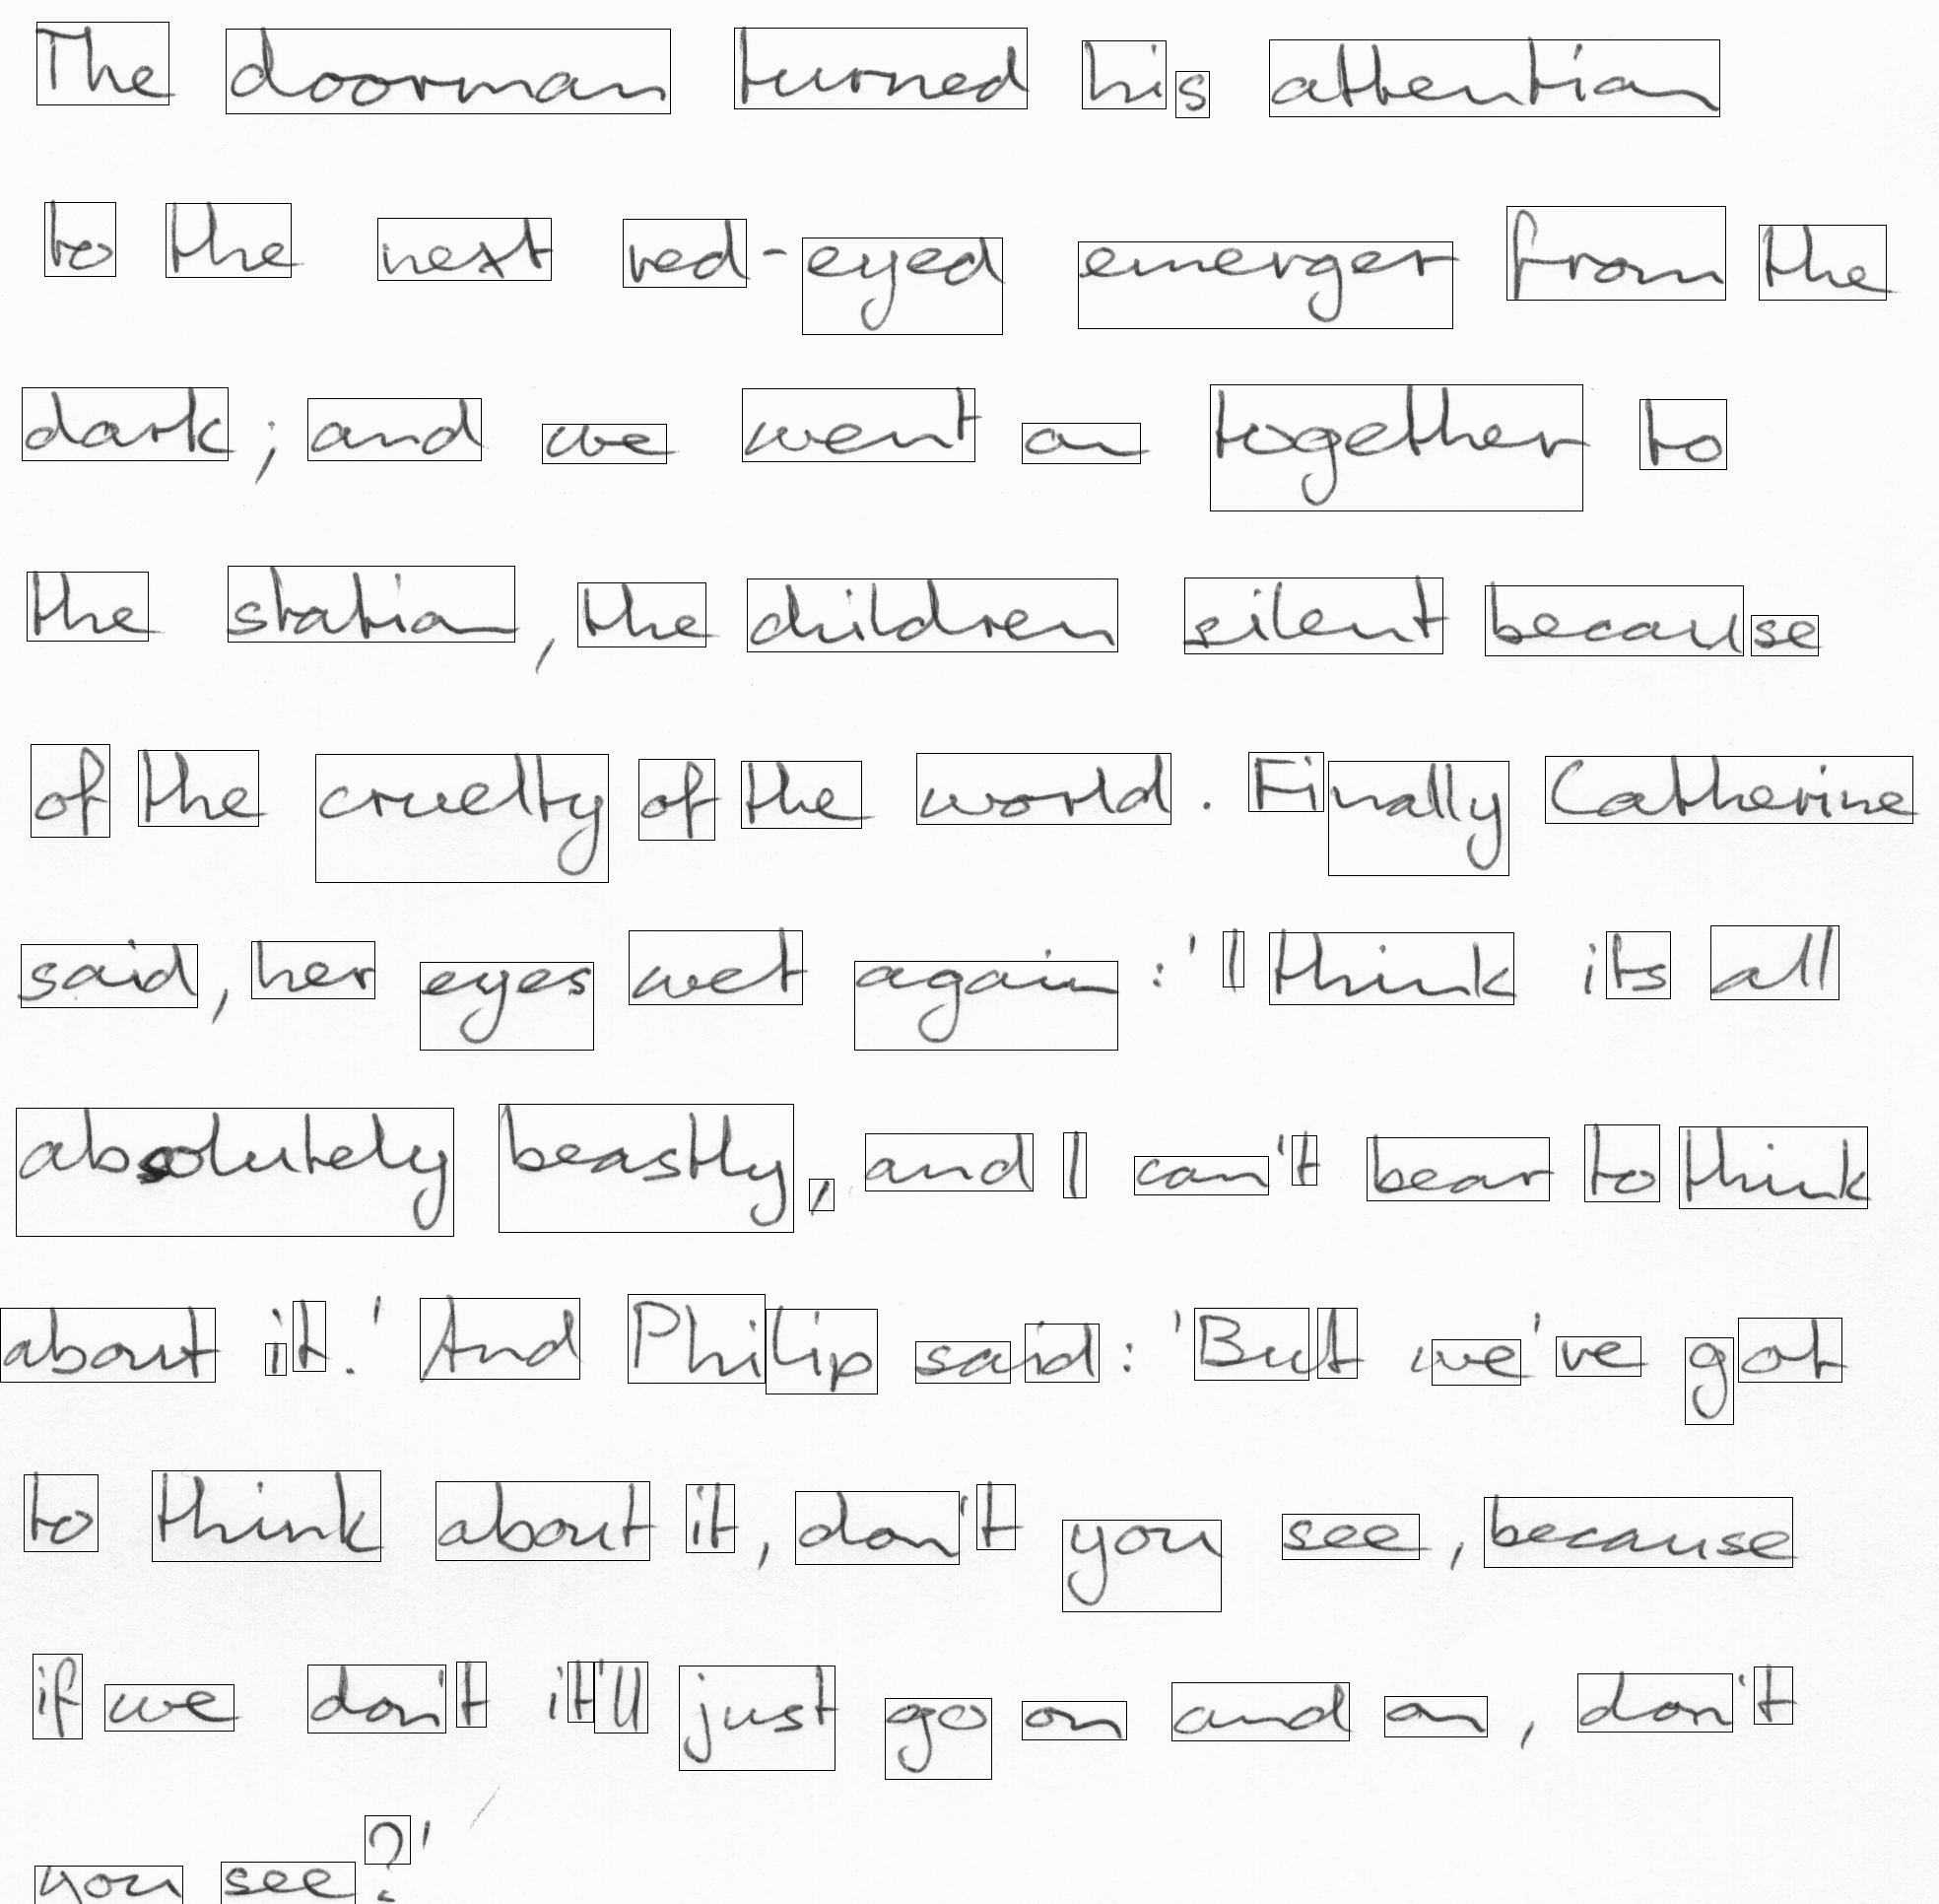

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def wordSegmentation(img, kernelSize, sigma, theta, minArea=0):
    ''' word segmentation '''
    sigma_X = sigma
    sigma_Y = sigma * theta
    height, width = img.shape
    # use gaussian blur and applies threshold
    imgFiltered = cv2.GaussianBlur(img, (kernelSize, kernelSize), sigmaX=sigma_X, sigmaY=sigma_Y)
    # Apply thresholding
    _, imgThres = cv2.threshold(imgFiltered, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    imgThres = 255 - imgThres
    # find connected components
    components, _ = cv2.findContours(imgThres, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    items = []
    for c in components:
        # skip small word candidates
        if cv2.contourArea(c) < minArea:
            continue
        # append bounding box and image of word to items list
        currBox = cv2.boundingRect(c)
        (x, y, w, h) = currBox

        if (w/h >= 3 and h < height/2 and y == 0):  # Loại chữ môn thi nếu bị dính
            continue
        else:
            currImg = img[max(0, y-5):y+h, x:x+5+w]  # +-5 de lay dau tieng Viet
            items.append([currBox, currImg])

    result = []
    temp = []
    for currBox, currImg in items:
        temp.append([currBox, currImg])
    # list of words, sorted by x-coordinate
    result.append(sorted(temp, key=lambda entry: entry[0][0]))
    return result

def main():
    name_crop = cv2.imread('/content/r06-137.png')
    name_crop = cv2.cvtColor(name_crop, cv2.COLOR_BGR2GRAY)

    # Corrected line: only pass the image to cv2_imshow
    cv2_imshow(name_crop)
    print('name_crop', name_crop.shape)

    result = wordSegmentation(name_crop, kernelSize=21, sigma=11, theta=4, minArea=500)
    draw = []
    i = 0
    for line in result:
        if len(line):
            for (_, w) in enumerate(line):
                (wordBox, wordImg) = w
                cv2_imshow(wordImg)
                print('wordImg', wordImg.shape)
                draw.append(wordBox)
                i = i + 1
    for wordBox in draw:
        (x, y, w, h) = wordBox
        cv2.rectangle(name_crop, (x, y), (x+w, y+h), 0, 1)

    # Display the final image
    cv2_imshow(name_crop)

if __name__ == '__main__':
    main()

Pretty good hah! But these drawbacks made me decide to choose Scale Space technique:

Both width and height must be pre-resized to be multiples of 32
Working good on the whole test paper but bad on the small images that we have cropped
High latency compared to the whole project combined (about 2s and 1s) due to it's complexity. And it's not necessary for my case
Scale Space technique:

Blurring
Otsu Threshold
Drawing Contour Those steps could be easily applied with OpenCV, and with a few more steps I can extract the position of words and then seperate them to recognize. OLD BUT GOOD

In [ ]:
pip install pytesseract

origH 2339    origW 1653
newH 640    newW 1024
[INFO] text detection took 2.199112 seconds
so luong boxes 24


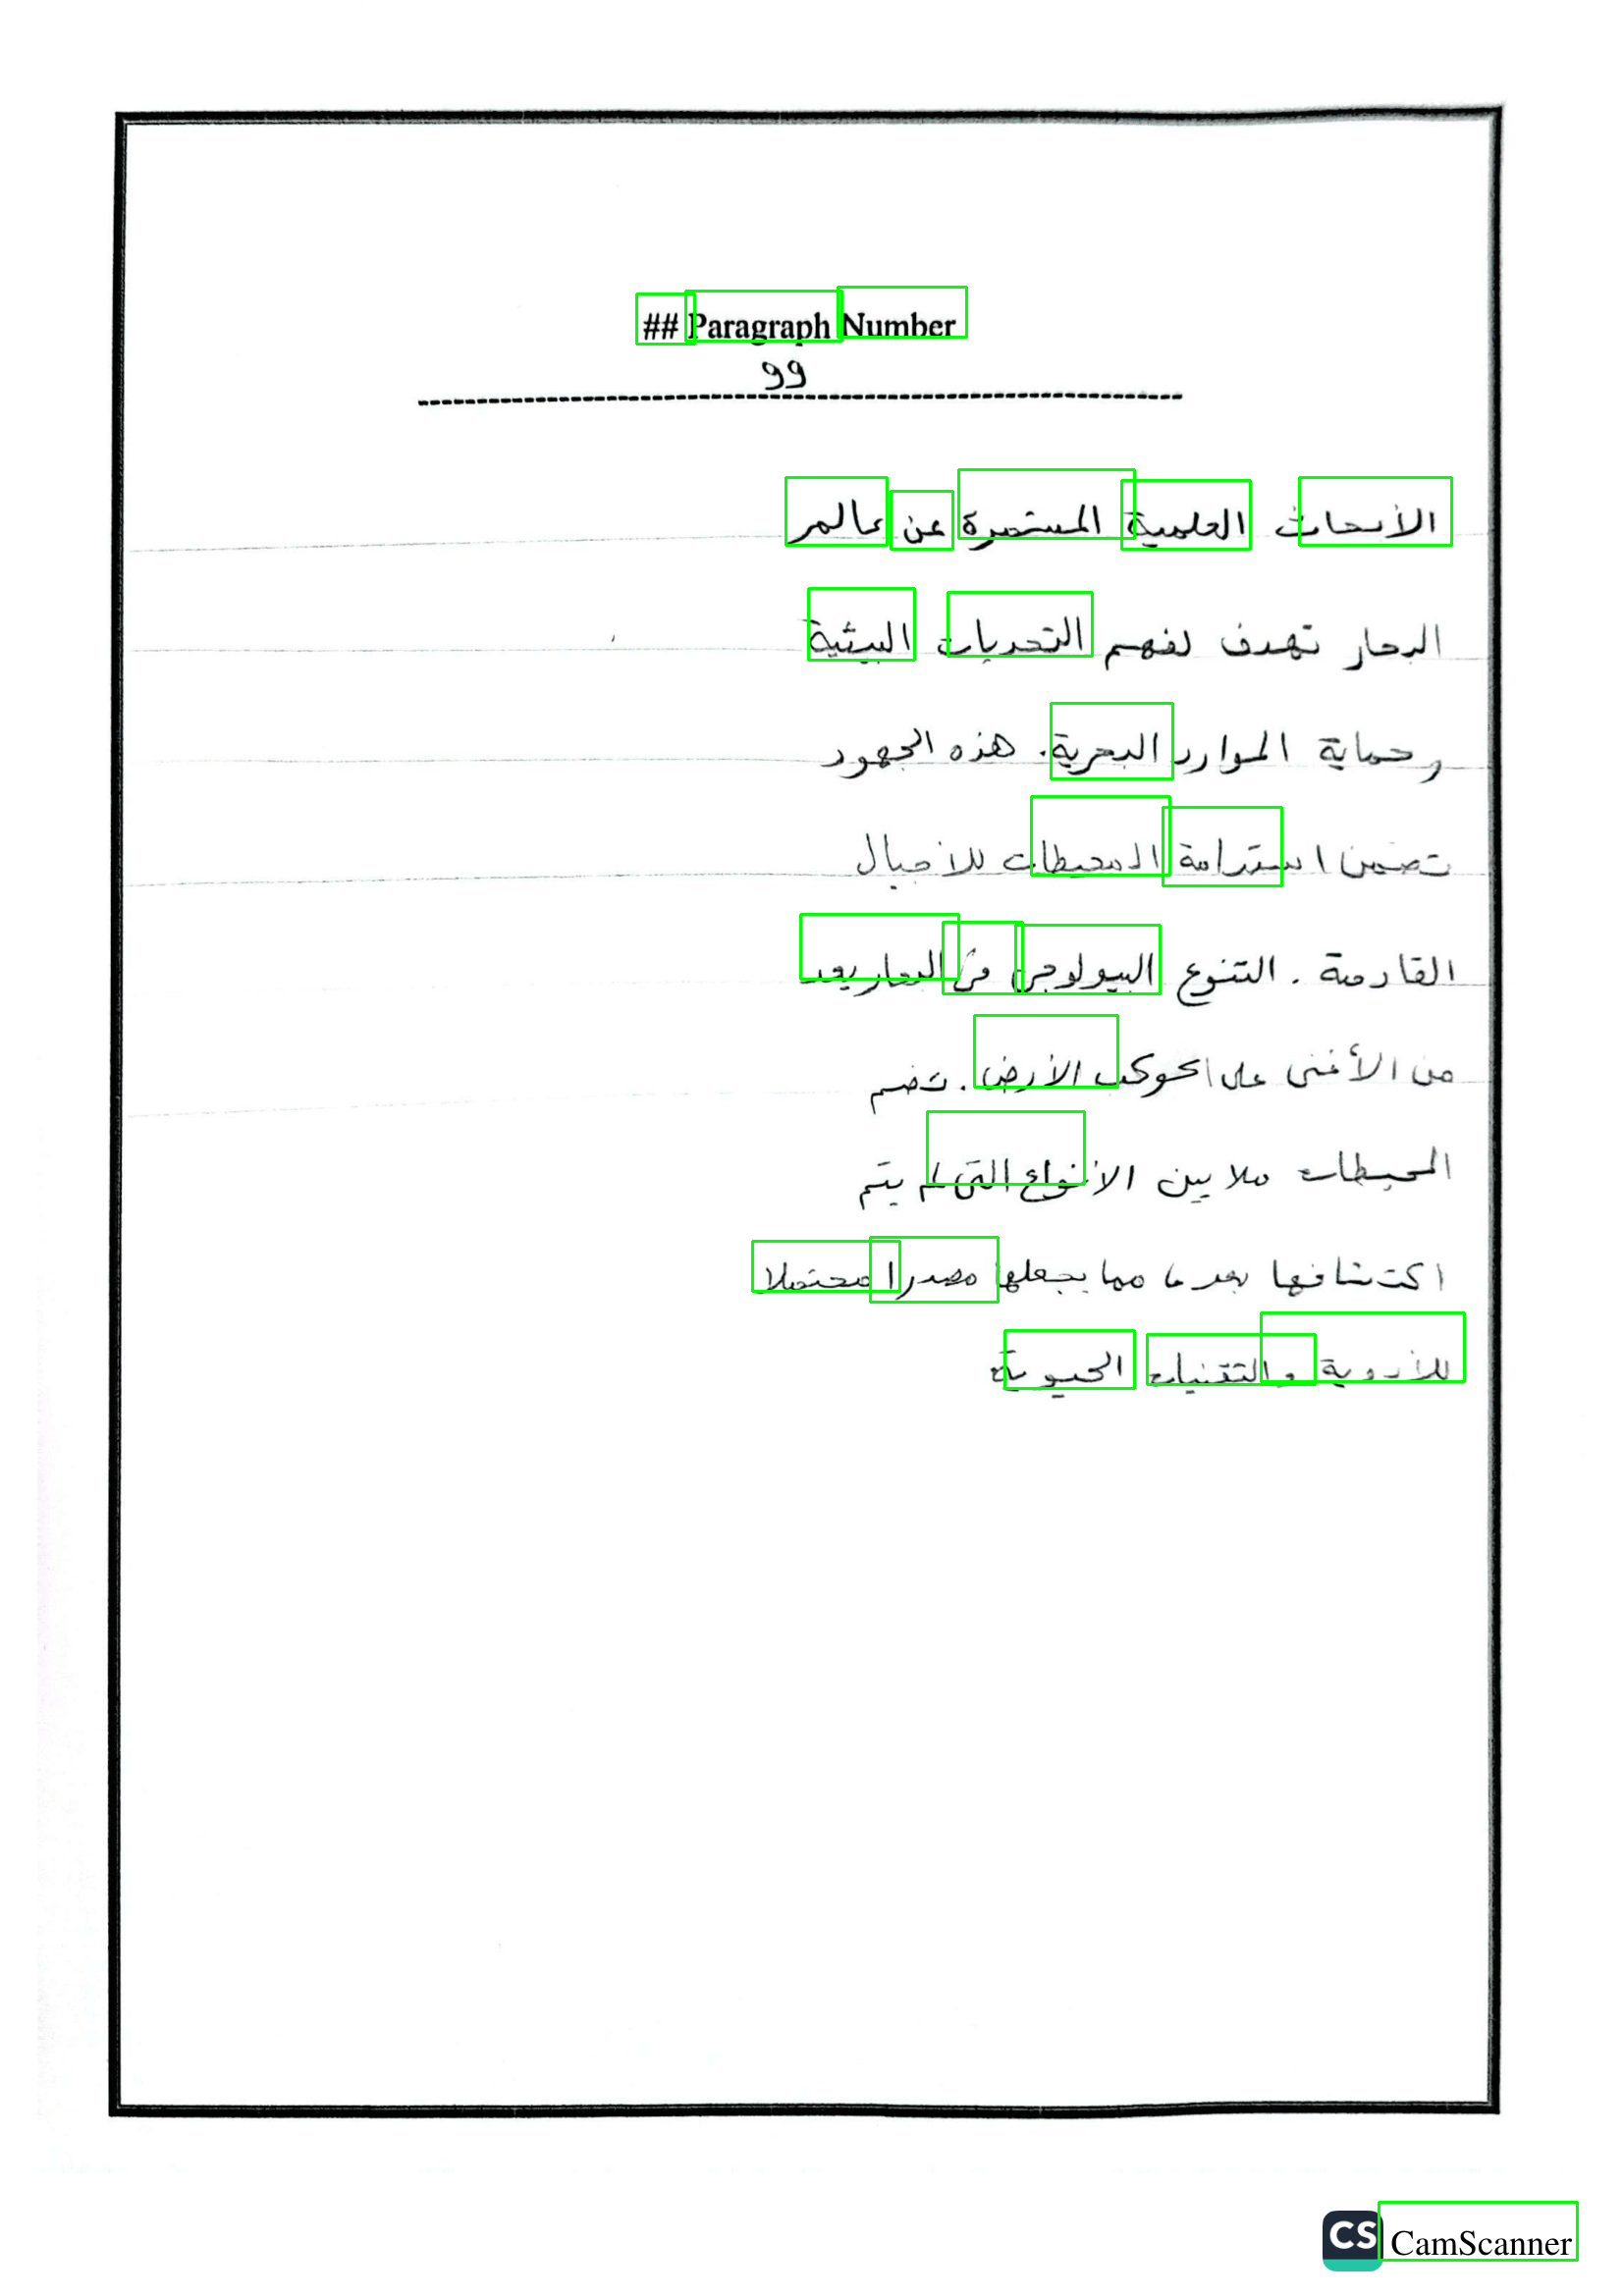

In [ ]:
##Loading the necessary packages
import numpy as np
import cv2
from imutils.object_detection import non_max_suppression
import pytesseract
from matplotlib import pyplot as plt
import time
from google.colab.patches import cv2_imshow
#Give location of the image to be read.
#"Example-images/ex24.jpg" image is being loaded here.


def EASTimg(image):

    #Saving a original image and shape
    orig = image.copy()
    (origH, origW) = image.shape[:2]
    print('origH',origH,'   origW',origW)
    #ratio = int((640*(origW/origH))/32)
    #print ('ratio',ratio)
    # set the new height and width to default 320 by using args #dictionary.

    #(newW, newH) = (576,64)
    (newW, newH) = (1024,640)
    print('newH',newH,'   newW',newW)
    #Calculate the ratio between original and new image for both height and weight.

    #This ratio will be used to translate bounding box location on the original image.

    rW = origW / float(newW)
    rH = origH / float(newH)

    # resize the original image to new dimensions
    image = cv2.resize(image, (newW, newH))
    (H, W) = image.shape[:2]

    # construct a blob from the image to forward pass it to EAST model
    blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
	    (123.68, 116.78, 103.94), swapRB=True, crop=False)

    #the mean values for the ImageNet training set are R=103.93, G=116.77, and B=123.68 (mean subtraction of blob)

    # load the pre-trained EAST model for text detection
    net = cv2.dnn.readNet('/content/frozen_east_text_detection.pb')


    # We would like to get two outputs from the EAST model.
    #1. Probabilty scores for the region whether that contains text or not.
    #2. Geometry of the text -- Coordinates of the bounding box detecting a text
    # The following two layer need to pulled from EAST model for achieving this.

    layerNames = [

            "feature_fusion/Conv_7/Sigmoid",

            "feature_fusion/concat_3"]

    start = time.time()
    net.setInput(blob)
    (scores, geometry) = net.forward(layerNames)
    end = time.time()
    # show timing information on text prediction
    print("[INFO] text detection took {:.6f} seconds".format(end - start))

    #Forward pass the blob from the image to get the desired output layers

    net.setInput(blob)
    (scores, geometry) = net.forward(layerNames)


    # Find predictions and  apply non-maxima suppression
    (boxes, confidence_val) = predictions(scores, geometry)
    boxes = non_max_suppression(np.array(boxes), probs=confidence_val)
    print('so luong boxes', len(boxes))
    for (startX, startY, endX, endY) in boxes:
	    # scale the bounding box coordinates based on the respective
	    # ratios
	    startX = int(startX * rW)
	    startY = int(startY * rH)
	    endX = int(endX * rW)
	    endY = int(endY * rH)
	    # draw the bounding box on the image
	    cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)

    #print ('confi_val',confidence_val )
    #print('boxes',boxes )
    #cv2.putText(image, str(confidence_val), (257,71),cv2.FONT_HERSHEY_DUPLEX, 1, (0, 255, 0), 2)
    #cv2.rectangle(image,(257,71),(288,85),(123,255,0),2)

    return orig

## Returns a bounding box and probability score if it is more than minimum confidence

def predictions(prob_score, geo):
    (numR, numC) = prob_score.shape[2:4]
    boxes = []
    confidence_val = []

    # loop over rows
    for y in range(0, numR):
            scoresData = prob_score[0, 0, y]
            x0 = geo[0, 0, y]
            x1 = geo[0, 1, y]
            x2 = geo[0, 2, y]
            x3 = geo[0, 3, y]
            anglesData = geo[0, 4, y]

            # loop over the number of columns
            for i in range(0, numC):
                if scoresData[i] < 0.5:
                        continue
                (offX, offY) = (i * 4.0, y * 4.0)

                # extracting the rotation angle for the prediction and computing the sine and cosine
                angle = anglesData[i]
                cos = np.cos(angle)
                sin = np.sin(angle)

                # using the geo volume to get the dimensions of the bounding box
                h = x0[i] + x2[i]
                w = x1[i] + x3[i]

                # compute start and end for the text pred bbox
                endX = int(offX + (cos * x1[i]) + (sin * x2[i]))
                endY = int(offY - (sin * x1[i]) + (cos * x2[i]))
                startX = int(endX - w)
                startY = int(endY - h)

                boxes.append((startX, startY, endX, endY))
                confidence_val.append(scoresData[i])

        # return bounding boxes and associated confidence_val
    return (boxes, confidence_val)

def main():
    img = cv2.imread('/content/p1-5.png', cv2.COLOR_BGR2GRAY)
    img = EASTimg(img)
    cv2_imshow (img)
    cv2.waitKey(0)

if __name__ =='__main__':
    main()